# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/Corentin312/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 79 (delta 9), reused 5 (delta 5), pack-reused 62 (from 2)
Receiving objects: 100% (79/79), 2.99 MiB | 20.94 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


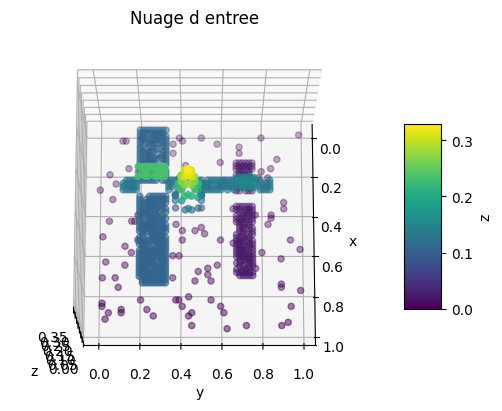

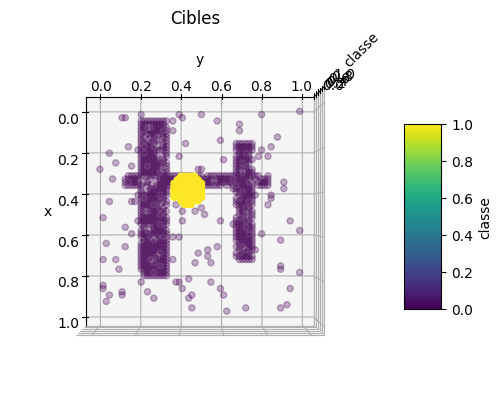

1


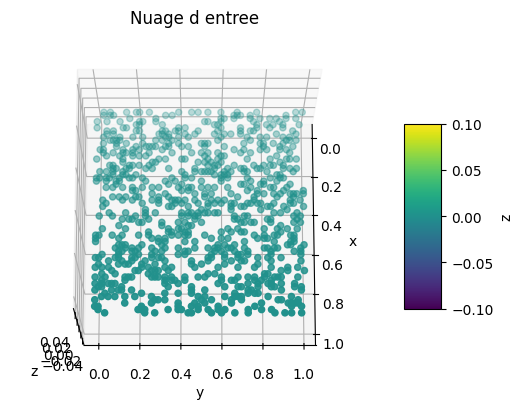

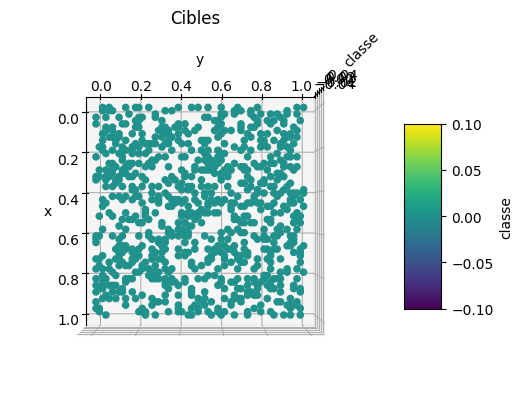

2


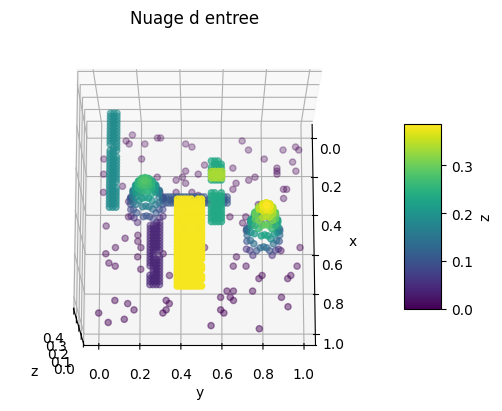

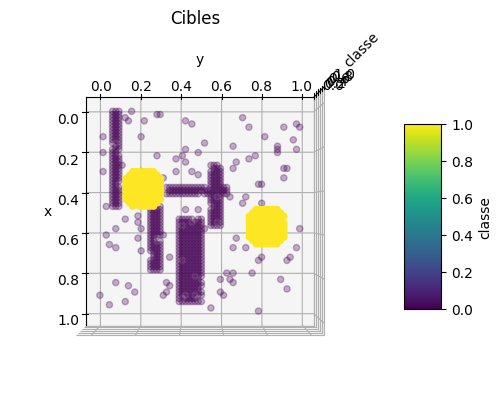

3


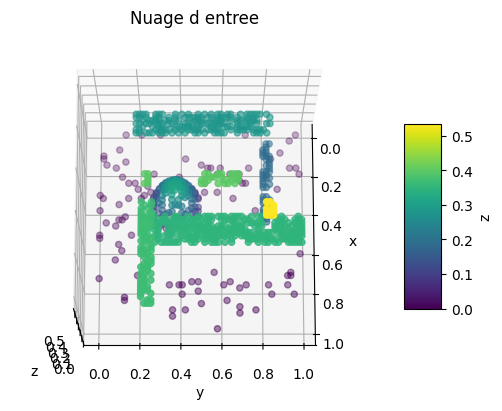

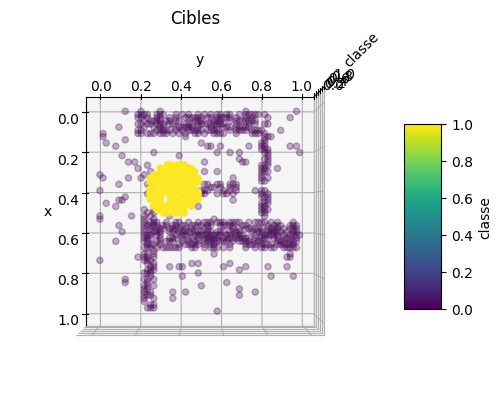

4


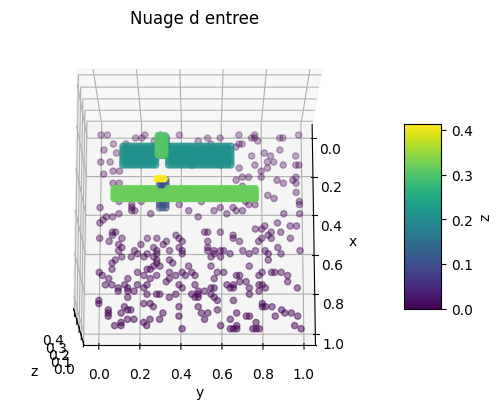

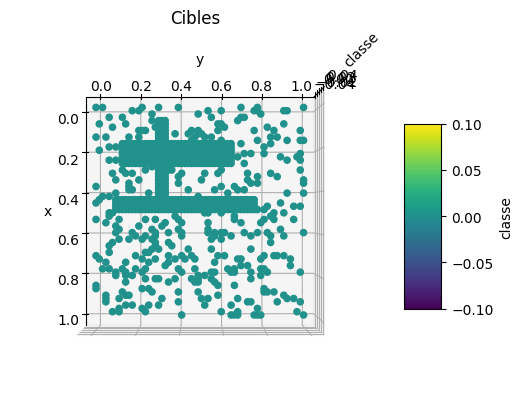

5


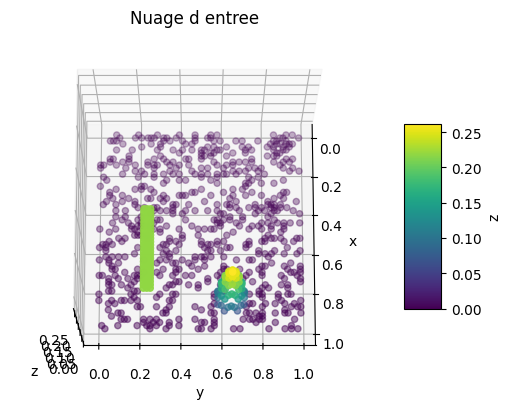

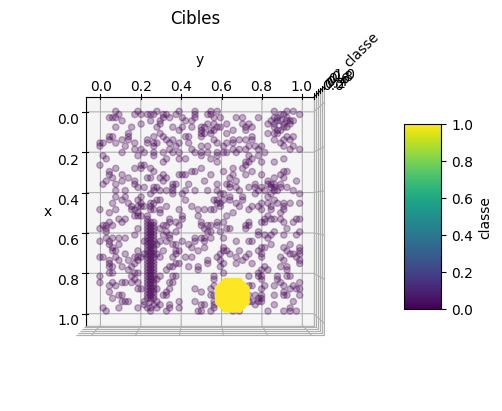

In [3]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [4]:
input_points.shape
# 6 batch size
# 3 nb_coords (x, y, z)
# 800 nb points

torch.Size([6, 3, 800])

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Non, ils sont echantillonés aléatoirement

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Il faut d'abord projeter la representation 3D en une representation 2D puis segmenter l'image obtenu comme nous l'avons déjà fait

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [5]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

"Our model will output n × m scores
for each of the n points and each of the m semantic sub-
categories" (Partie 3)

In [6]:
output.shape
# 6 batch size
# 800 nb de points
# 2 nombre de classes

torch.Size([6, 800, 2])

**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

Les couches MultiLayerPerceptron, maxpool et concat
Shared signifie qu'elles sont partagéees entre tous les points pour que l'ordre des points n'affecte pas le résultat

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [10]:
from utils_probleme2 import PointNetSegLoss


optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

TypeError: cannot assign 'numpy.ndarray' object to buffer 'weight' (torch Tensor or None required)

In [12]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()


In [15]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet = pointnet.to(device)

for epoch in range(1, n_epochs):
  for batch in range(1,n_batch_per_epoch):
    input_points, target_list, _ = gen_pointcloud(batch_size)
    input_points = input_points.to(device)
    target_list = target_list.to(device)

    optimizer.zero_grad()
    outputs, _, _ = pointnet(input_points)

    # Transposition for loss calculation
    proba_pred_list = outputs.transpose(1, 2)
    loss = criterion(proba_pred_list, target_list)
    loss.backward()
    optimizer.step()

    # 2) Afficher à chaque époque la justesse des prédictions
  with torch.no_grad():
    input_points, target_list, _ = gen_pointcloud(batch_size)
    input_points = input_points.to(device)
    target_list = target_list.to(device)
    outputs, _, _ = pointnet(input_points)

    # Get predicted classes
    pred_list = outputs.transpose(1, 2).max(1)[1]

    # Calculate accuracy
    accuracy = (pred_list == target_list).float().mean()
    print(f"Epoch {epoch}, Accuracy: {accuracy.item()}")


Epoch 1, Accuracy: 0.5399609208106995
Epoch 2, Accuracy: 0.5190624594688416
Epoch 3, Accuracy: 0.5323827862739563
Epoch 4, Accuracy: 0.5516210794448853
Epoch 5, Accuracy: 0.5453320145606995
Epoch 6, Accuracy: 0.5690624713897705
Epoch 7, Accuracy: 0.5186523199081421
Epoch 8, Accuracy: 0.5874218344688416
Epoch 9, Accuracy: 0.545214831829071
Epoch 10, Accuracy: 0.5936132669448853
Epoch 11, Accuracy: 0.5755273103713989
Epoch 12, Accuracy: 0.5531445145606995
Epoch 13, Accuracy: 0.5864062309265137
Epoch 14, Accuracy: 0.59814453125
Epoch 15, Accuracy: 0.6057812571525574
Epoch 16, Accuracy: 0.5979687571525574
Epoch 17, Accuracy: 0.6114843487739563
Epoch 18, Accuracy: 0.6405078172683716
Epoch 19, Accuracy: 0.6445898413658142
Epoch 20, Accuracy: 0.6437304615974426
Epoch 21, Accuracy: 0.6530468463897705
Epoch 22, Accuracy: 0.6709374785423279
Epoch 23, Accuracy: 0.617382824420929
Epoch 24, Accuracy: 0.6326757669448853
Epoch 25, Accuracy: 0.6392577886581421
Epoch 26, Accuracy: 0.6678710579872131
Ep

Note : l'accuracy n'est pas exceptionnelle car ce n'est pas la bonne loss function\
J'ai oublié un +1 dans les for

In [17]:
!pip install huggingface_hub
from huggingface_hub import hf_hub_download

file_path = hf_hub_download(repo_id="nanopiero/pointnet_igloos", filename="pointnet_500_ep.pth")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pointnet_500_ep.pth:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Accuracy with loaded weights: 0.8531249761581421
0


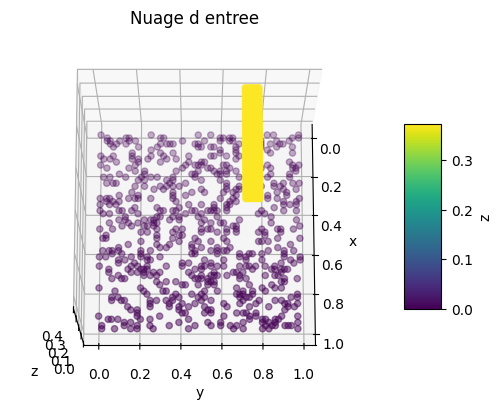

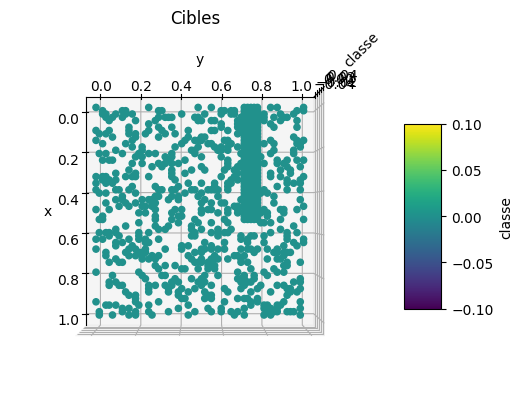

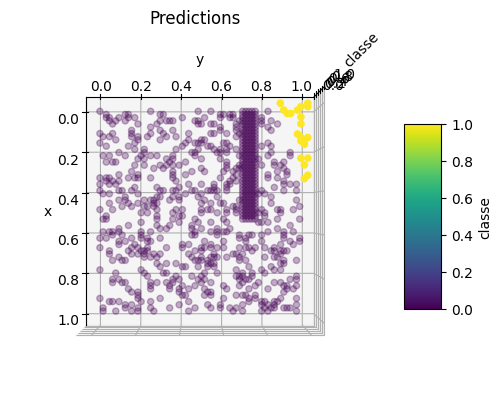

1


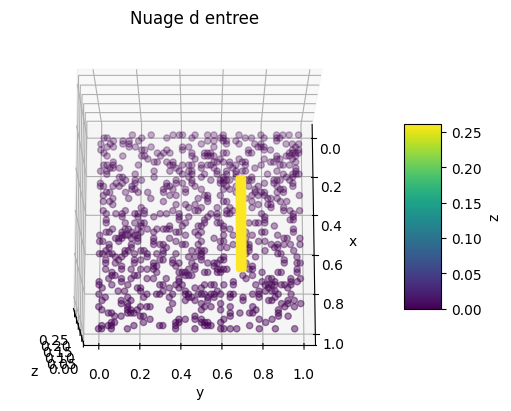

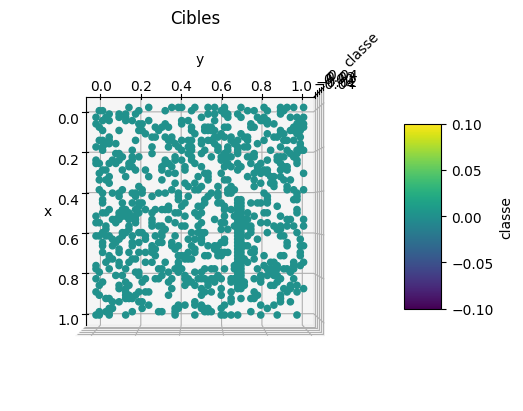

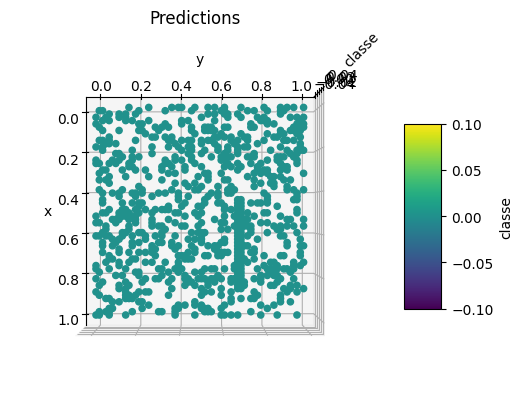

2


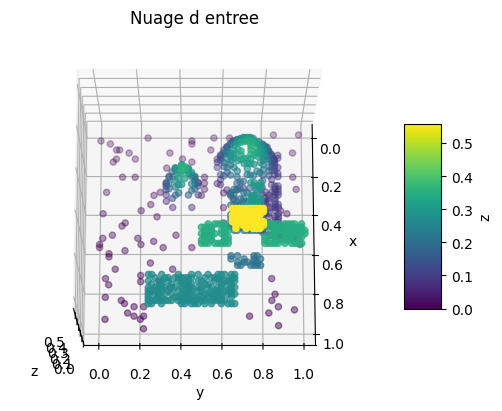

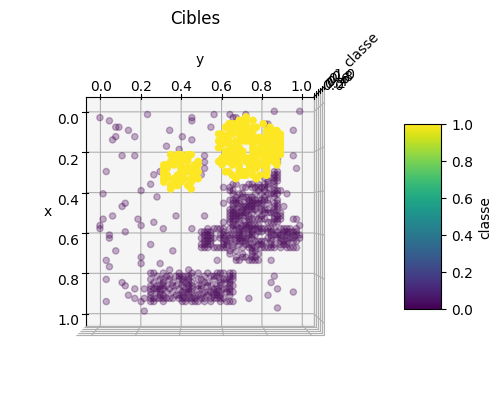

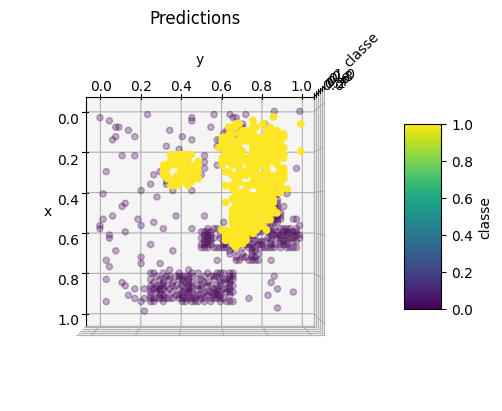

3


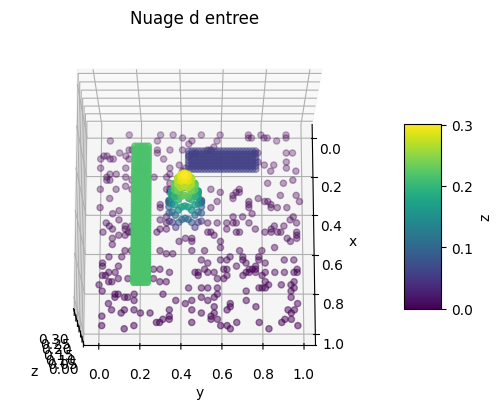

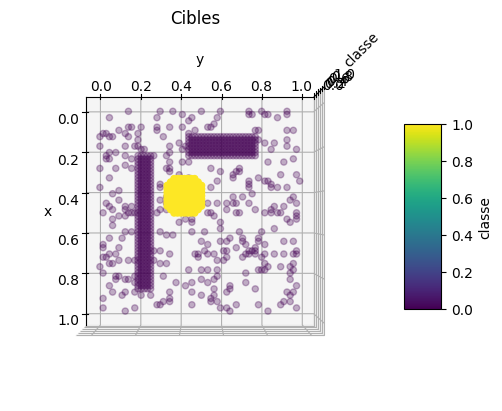

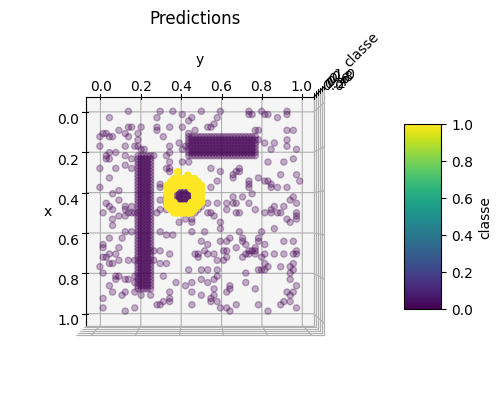

4


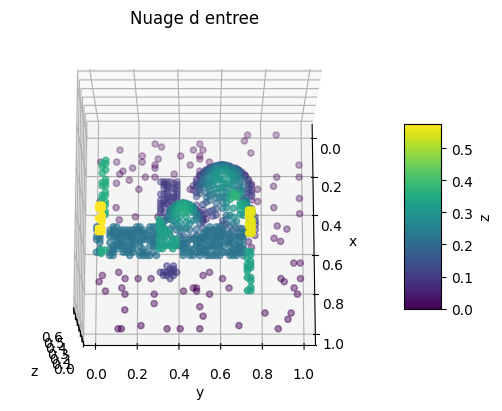

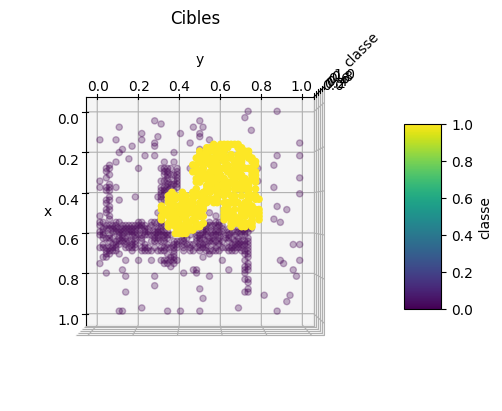

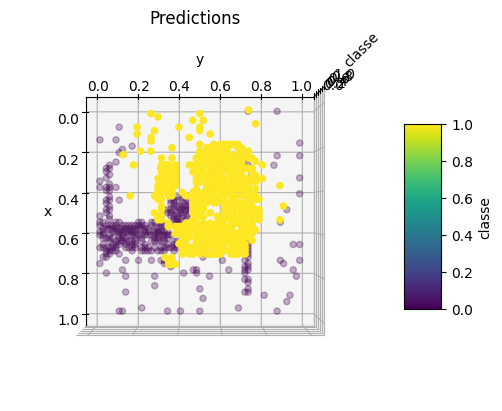

5


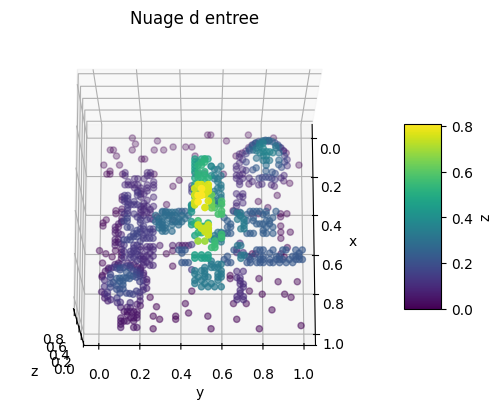

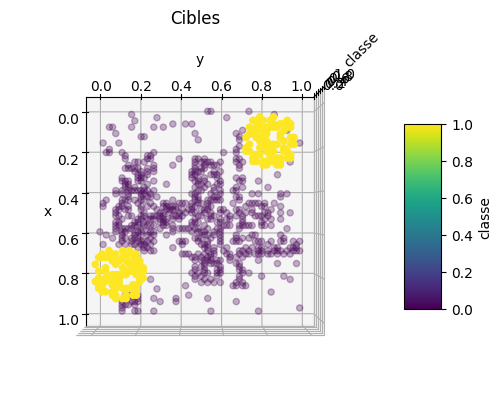

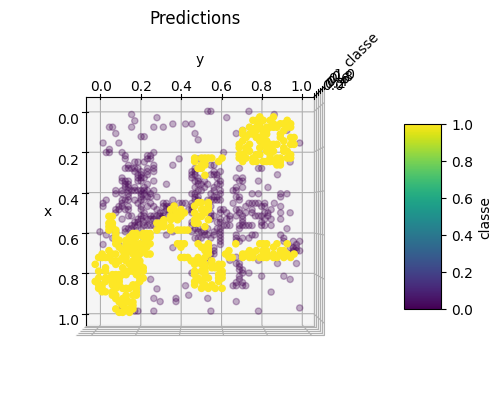

In [24]:
input_points, target_list , target_points = gen_pointcloud(6)


state_dict = torch.load(file_path, weights_only=True)
pointnet2 = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()
pointnet2.load_state_dict(state_dict)


# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()
with torch.no_grad():
    proba_pred_list, _, _ = pointnet2(input_points.cuda())
    pred_list = proba_pred_list.transpose(1, 2).max(1)[1].cpu()

# Accuracy:
accuracy = (pred_list == target_list.cpu()).float().mean()
print(f"Accuracy with loaded weights: {accuracy.item()}")

# Tracé
for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  predicted_target_points = target_points[i].clone()
  predicted_target_points[2] = pred_list[i].cpu()  # Replace z-coordinate with predictions

  plot_triplets(predicted_target_points.transpose(0, 1),
                title='Predictions',
                cbar_label='classe')
